# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = 'data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

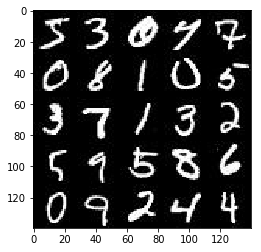

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

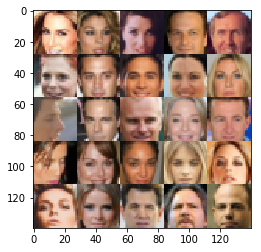

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [46]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None,image_width,image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None,z_dim])
    learning_rate = tf.placeholder(tf.float32)
    

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [63]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    leaky_relu = lambda x: tf.maximum(alpha*x,x)
    with tf.variable_scope("discriminator", reuse=reuse):
        # Conv1 28x28
        x1 = tf.layers.conv2d(images,64,5, strides=2, padding ="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = leaky_relu(x1)
        
        # Conv2 14x14x3
        x2 = tf.layers.conv2d(relu1,128,5, strides=2, padding ="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        
        # Conv3 7x7x3
        x3 = tf.layers.conv2d(relu2,256,5, strides=2, padding ="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3,training=True)
        drop3 = tf.nn.dropout(bn3,keep_prob=.2)
        relu3 = leaky_relu(bn3)
        
        # Conv4
        #x4 = tf.layers.conv2d(relu3,512,5, strides=1, padding ="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        #bn4 = tf.layers.batch_normalization(x4,training=True)
        #drop4 = tf.nn.dropout(bn4,keep_prob=.2)
        #relu4 = leaky_relu(drop4)
        # Flattening
        flat = tf.reshape(relu3,(-1,4*4*256))
        # Fully connected
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    leaky_relu = lambda x: tf.maximum(alpha*x,x)
    
    with tf.variable_scope("generator", reuse = not is_train):
        # FC1 28
        
        x0 = tf.layers.dense(z,7*7*512)
        x0 = tf.reshape(x0, (-1,7,7,512))
        bn0 = tf.layers.batch_normalization(x0, training=is_train)
        relu0 = leaky_relu(bn0)
        
        #x1 = tf.layers.conv2d_transpose(relu0,1024,5,strides=1, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        #bn1 = tf.layers.batch_normalization(x1,training=is_train)
        #relu1 = leaky_relu(bn1)
        
        x1 = tf.layers.conv2d_transpose(relu0,512,5,strides=1, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1,training=is_train)
        relu1 = leaky_relu(bn1)
        
        x1 = tf.layers.conv2d_transpose(relu1,256,5,strides=1, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1,training=is_train)
        relu1 = leaky_relu(bn1)
        
        # Conv2 7
        
        x2 = tf.layers.conv2d_transpose(relu1,128,5,strides=1, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2,training=is_train)
        relu2 = leaky_relu(bn2)
        
        # Conv3 14
        
        x3 = tf.layers.conv2d_transpose(relu2,64,5,strides=2, padding="same",kernel_initializer=tf.truncated_normal_initializer(stddev=0.2))
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(bn3)
        #drop3 = tf.nn.dropout(relu3,keep_prob=.25)
        
        #Conv 28
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding="same",kernel_initializer=tf.truncated_normal_initializer(stddev=0.2))
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Building the network
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * (1-.01)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake) * (1-.01)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.ones_like(d_logits_fake)))
    
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith("discriminator")]
    g_updates = [opt for opt in update_ops if opt.name.startswith("generator")]
    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [76]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    print_ = 10
    show_ = 100
    losses = []
    n_images = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images *=2.0
                images_z = np.random.uniform(-1,1,size = (batch_size,z_dim))
                _ =sess.run(d_opt, feed_dict= {input_real:batch_images,
                                               input_z:images_z,
                                              lr:learning_rate})
                _ =sess.run(g_opt, feed_dict = {input_z:images_z,
                                              lr:learning_rate})
                if steps % print_ == 0:
                    train_loss_d = sess.run(d_loss,feed_dict={input_z:images_z, 
                                                              input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:images_z})
                    print("epoch descrim --->{}--{}".format(epoch_i,train_loss_d))
                    print("epoch generate --->{}--{}".format(epoch_i,train_loss_g))
                    losses.append((train_loss_d,train_loss_g))
                if steps % show_ == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)
                    
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [24]:



batch_size = 16
z_dim = 128
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)



KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch descrim --->0--0.12288765609264374
epoch generate --->0--26.474822998046875
epoch descrim --->0--0.11455971002578735
epoch generate --->0--19.789167404174805
epoch descrim --->0--0.09986275434494019
epoch generate --->0--4.059434413909912
epoch descrim --->0--0.6891483068466187
epoch generate --->0--13.72348690032959
epoch descrim --->0--1.6083072423934937
epoch generate --->0--0.8250211477279663
epoch descrim --->0--1.1676992177963257
epoch generate --->0--1.160280466079712
epoch descrim --->0--0.3533862829208374
epoch generate --->0--2.104727268218994
epoch descrim --->0--0.9184308052062988
epoch generate --->0--0.7065044641494751
epoch descrim --->0--0.16958776116371155
epoch generate --->0--2.832246780395508
epoch descrim --->0--0.19900107383728027
epoch generate --->0--6.0543928146362305


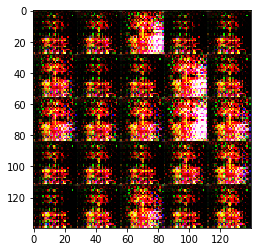

epoch descrim --->0--0.25106170773506165
epoch generate --->0--2.221233367919922
epoch descrim --->0--0.0935354232788086
epoch generate --->0--3.960470199584961
epoch descrim --->0--0.07472200691699982
epoch generate --->0--5.209677696228027
epoch descrim --->0--0.28785789012908936
epoch generate --->0--1.7493082284927368
epoch descrim --->0--1.0544204711914062
epoch generate --->0--1.43543541431427
epoch descrim --->0--1.3313113451004028
epoch generate --->0--4.342926025390625
epoch descrim --->0--1.9766151905059814
epoch generate --->0--0.5963854193687439
epoch descrim --->0--0.7582939863204956
epoch generate --->0--1.390737771987915
epoch descrim --->0--0.3826152980327606
epoch generate --->0--2.7012557983398438
epoch descrim --->0--0.42537960410118103
epoch generate --->0--3.078897476196289


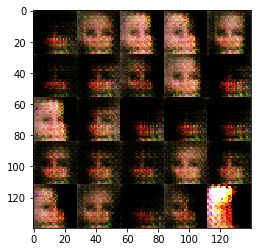

epoch descrim --->0--0.503023087978363
epoch generate --->0--1.6333417892456055
epoch descrim --->0--1.118044376373291
epoch generate --->0--0.5118184685707092
epoch descrim --->0--0.885640561580658
epoch generate --->0--0.6320070028305054
epoch descrim --->0--0.6251703500747681
epoch generate --->0--1.3794965744018555
epoch descrim --->0--1.5332796573638916
epoch generate --->0--1.7121716737747192
epoch descrim --->0--0.28842929005622864
epoch generate --->0--2.2634778022766113
epoch descrim --->0--0.6891617178916931
epoch generate --->0--1.1859898567199707
epoch descrim --->0--1.0894718170166016
epoch generate --->0--0.5330286026000977
epoch descrim --->0--1.729034423828125
epoch generate --->0--0.4876287579536438
epoch descrim --->0--0.9398224949836731
epoch generate --->0--1.0795304775238037


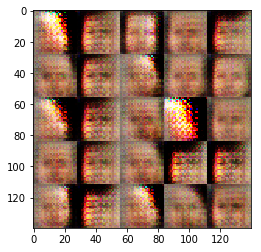

epoch descrim --->0--0.5391269326210022
epoch generate --->0--1.4199492931365967
epoch descrim --->0--0.30302780866622925
epoch generate --->0--2.1654250621795654
epoch descrim --->0--1.0572450160980225
epoch generate --->0--1.0093789100646973
epoch descrim --->0--0.3738754987716675
epoch generate --->0--1.7000312805175781
epoch descrim --->0--0.5725977420806885
epoch generate --->0--1.5296974182128906
epoch descrim --->0--0.5817041993141174
epoch generate --->0--1.3754708766937256
epoch descrim --->0--0.500826895236969
epoch generate --->0--1.751000165939331
epoch descrim --->0--0.9964456558227539
epoch generate --->0--0.5917776823043823
epoch descrim --->0--0.48082005977630615
epoch generate --->0--2.4790902137756348
epoch descrim --->0--0.4904433488845825
epoch generate --->0--1.8731255531311035


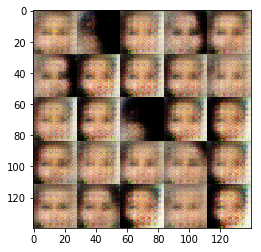

epoch descrim --->0--1.2654454708099365
epoch generate --->0--1.642704725265503
epoch descrim --->0--0.46520480513572693
epoch generate --->0--1.3805794715881348
epoch descrim --->0--0.5046737194061279
epoch generate --->0--2.5274410247802734
epoch descrim --->0--0.3035055994987488
epoch generate --->0--2.0764882564544678
epoch descrim --->0--0.5496121644973755
epoch generate --->0--2.0561916828155518
epoch descrim --->0--0.6938421726226807
epoch generate --->0--1.9804848432540894
epoch descrim --->0--1.4512027502059937
epoch generate --->0--0.4316946864128113
epoch descrim --->0--0.6069624423980713
epoch generate --->0--2.457448959350586
epoch descrim --->0--1.1823832988739014
epoch generate --->0--0.7494791746139526
epoch descrim --->0--1.356476068496704
epoch generate --->0--0.9455204010009766


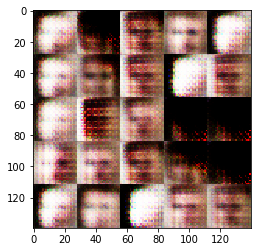

epoch descrim --->0--0.7489264011383057
epoch generate --->0--1.8516210317611694
epoch descrim --->0--1.3508760929107666
epoch generate --->0--0.7820425629615784
epoch descrim --->0--0.6442149877548218
epoch generate --->0--1.8156933784484863
epoch descrim --->0--0.9344009757041931
epoch generate --->0--3.2637624740600586
epoch descrim --->0--0.7591627240180969
epoch generate --->0--0.8384705185890198
epoch descrim --->0--0.46431630849838257
epoch generate --->0--1.4769648313522339
epoch descrim --->0--0.6726266145706177
epoch generate --->0--1.1560964584350586
epoch descrim --->0--0.31994402408599854
epoch generate --->0--1.8242335319519043
epoch descrim --->0--2.327416181564331
epoch generate --->0--3.8025128841400146
epoch descrim --->0--0.7780210375785828
epoch generate --->0--1.0396723747253418


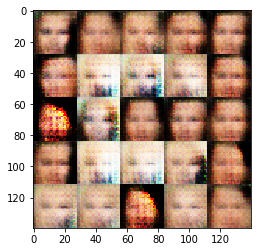

epoch descrim --->0--0.8010561466217041
epoch generate --->0--2.1776809692382812
epoch descrim --->0--2.1449310779571533
epoch generate --->0--4.030900001525879
epoch descrim --->0--0.9842174053192139
epoch generate --->0--2.6688342094421387
epoch descrim --->0--0.8145967721939087
epoch generate --->0--0.7805407047271729
epoch descrim --->0--0.9005484580993652
epoch generate --->0--0.9171090126037598
epoch descrim --->0--1.414495825767517
epoch generate --->0--0.36845821142196655
epoch descrim --->0--0.5601391792297363
epoch generate --->0--1.6278667449951172
epoch descrim --->0--1.0040258169174194
epoch generate --->0--1.0964404344558716
epoch descrim --->0--0.7626161575317383
epoch generate --->0--1.245487928390503
epoch descrim --->0--0.3648124933242798
epoch generate --->0--1.5097471475601196


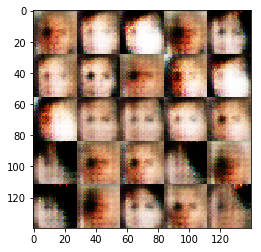

epoch descrim --->0--1.7597187757492065
epoch generate --->0--0.26895222067832947
epoch descrim --->0--1.129999041557312
epoch generate --->0--0.7134894132614136
epoch descrim --->0--0.47715887427330017
epoch generate --->0--2.505404233932495
epoch descrim --->0--0.9559897780418396
epoch generate --->0--0.8241226673126221
epoch descrim --->0--1.0450489521026611
epoch generate --->0--1.4756245613098145
epoch descrim --->0--0.6709654331207275
epoch generate --->0--1.2671014070510864
epoch descrim --->0--1.4440163373947144
epoch generate --->0--0.6517560482025146
epoch descrim --->0--1.9643025398254395
epoch generate --->0--0.2034992128610611
epoch descrim --->0--0.6173036694526672
epoch generate --->0--1.4518301486968994
epoch descrim --->0--0.5628248453140259
epoch generate --->0--1.5793474912643433


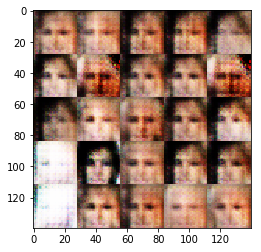

epoch descrim --->0--0.5354118347167969
epoch generate --->0--1.3770123720169067
epoch descrim --->0--1.8497247695922852
epoch generate --->0--0.2403922826051712
epoch descrim --->0--0.7392787933349609
epoch generate --->0--1.1334567070007324
epoch descrim --->0--0.7485174536705017
epoch generate --->0--1.2719764709472656
epoch descrim --->0--0.8261642456054688
epoch generate --->0--0.7513079643249512
epoch descrim --->0--0.8937046527862549
epoch generate --->0--0.9314510822296143
epoch descrim --->0--0.5841650366783142
epoch generate --->0--1.410547137260437
epoch descrim --->0--1.0374352931976318
epoch generate --->0--0.5824089050292969
epoch descrim --->0--0.8886709213256836
epoch generate --->0--0.8640847206115723
epoch descrim --->0--0.697264552116394
epoch generate --->0--1.1734445095062256


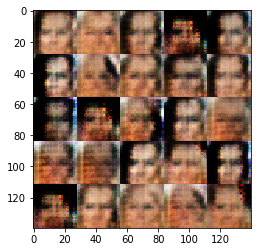

epoch descrim --->0--0.9833595156669617
epoch generate --->0--1.1359609365463257
epoch descrim --->0--1.7947769165039062
epoch generate --->0--0.3425682485103607
epoch descrim --->0--0.37122097611427307
epoch generate --->0--1.6073384284973145
epoch descrim --->0--0.45264407992362976
epoch generate --->0--2.19938325881958
epoch descrim --->0--1.5955400466918945
epoch generate --->0--0.48243051767349243
epoch descrim --->0--0.6116788387298584
epoch generate --->0--1.1085208654403687
epoch descrim --->0--1.879880666732788
epoch generate --->0--0.2209911346435547
epoch descrim --->0--1.018762469291687
epoch generate --->0--0.8568187952041626
epoch descrim --->0--0.818778395652771
epoch generate --->0--2.181313991546631
epoch descrim --->0--0.513224720954895
epoch generate --->0--1.8597629070281982


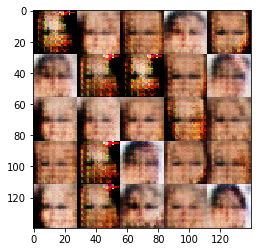

epoch descrim --->0--1.0231927633285522
epoch generate --->0--0.6562991738319397
epoch descrim --->0--0.8768212199211121
epoch generate --->0--1.2233039140701294
epoch descrim --->0--0.5869914889335632
epoch generate --->0--1.4791431427001953
epoch descrim --->0--0.7388410568237305
epoch generate --->0--0.9476935863494873
epoch descrim --->0--0.762324333190918
epoch generate --->0--0.9089670181274414
epoch descrim --->0--0.6646130084991455
epoch generate --->0--2.263599395751953
epoch descrim --->0--1.5793150663375854
epoch generate --->0--0.4372764825820923
epoch descrim --->0--1.1393921375274658
epoch generate --->0--0.6070912480354309
epoch descrim --->0--0.8875086307525635
epoch generate --->0--0.8586831092834473
epoch descrim --->0--0.6005783081054688
epoch generate --->0--2.5814461708068848


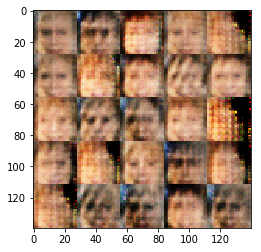

epoch descrim --->0--1.5050550699234009
epoch generate --->0--0.4498373866081238
epoch descrim --->0--0.3976619243621826
epoch generate --->0--2.057668447494507
epoch descrim --->0--3.5306646823883057
epoch generate --->0--6.5215606689453125
epoch descrim --->0--1.013907551765442
epoch generate --->0--2.4163849353790283
epoch descrim --->0--0.6598120331764221
epoch generate --->0--1.344970703125
epoch descrim --->0--1.0777829885482788
epoch generate --->0--0.5252816677093506
epoch descrim --->0--0.6779709458351135
epoch generate --->0--2.1885955333709717
epoch descrim --->0--0.418312668800354
epoch generate --->0--1.4173659086227417
epoch descrim --->0--1.2954356670379639
epoch generate --->0--2.2691903114318848
epoch descrim --->0--1.1789250373840332
epoch generate --->0--0.5921987891197205


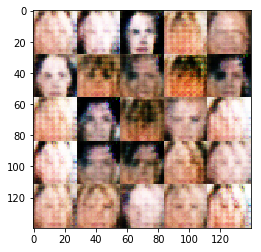

epoch descrim --->0--1.518593430519104
epoch generate --->0--2.8896470069885254
epoch descrim --->0--0.47644180059432983
epoch generate --->0--2.1626296043395996
epoch descrim --->0--0.5093036890029907
epoch generate --->0--1.39919912815094
epoch descrim --->0--0.7083078622817993
epoch generate --->0--0.9532128572463989
epoch descrim --->0--0.7924638986587524
epoch generate --->0--0.7986528873443604
epoch descrim --->0--2.961407423019409
epoch generate --->0--6.305649757385254
epoch descrim --->0--1.4557468891143799
epoch generate --->0--0.4002710282802582
epoch descrim --->0--0.9160785675048828
epoch generate --->0--0.7158930897712708
epoch descrim --->0--0.6129580736160278
epoch generate --->0--2.1776316165924072
epoch descrim --->0--0.8784893751144409
epoch generate --->0--0.8538352251052856


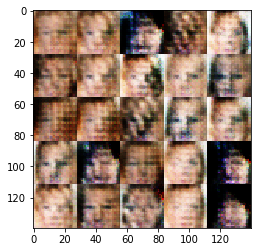

epoch descrim --->0--0.7649369239807129
epoch generate --->0--1.11803138256073
epoch descrim --->0--2.8573784828186035
epoch generate --->0--0.07357262074947357
epoch descrim --->0--1.858298897743225
epoch generate --->0--0.2698042392730713
epoch descrim --->0--0.7125190496444702
epoch generate --->0--1.4078822135925293
epoch descrim --->0--0.85532146692276
epoch generate --->0--0.805202841758728
epoch descrim --->0--1.1677210330963135
epoch generate --->0--0.5917586088180542
epoch descrim --->0--0.8434760570526123
epoch generate --->0--0.937537431716919
epoch descrim --->0--1.3361680507659912
epoch generate --->0--0.4760091304779053
epoch descrim --->0--1.6519972085952759
epoch generate --->0--0.2708907127380371
epoch descrim --->0--0.43722787499427795
epoch generate --->0--2.4938035011291504


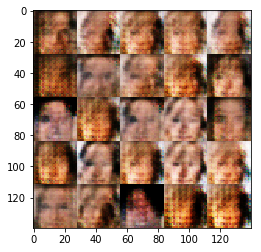

epoch descrim --->0--0.8103630542755127
epoch generate --->0--0.9223740100860596
epoch descrim --->0--1.9051932096481323
epoch generate --->0--0.22364486753940582
epoch descrim --->0--2.1636838912963867
epoch generate --->0--0.20430758595466614
epoch descrim --->0--0.4899452328681946
epoch generate --->0--1.9546858072280884
epoch descrim --->0--0.8753656148910522
epoch generate --->0--1.1802922487258911
epoch descrim --->0--1.1180381774902344
epoch generate --->0--0.6499905586242676
epoch descrim --->0--0.91059809923172
epoch generate --->0--1.153731107711792
epoch descrim --->0--0.8233076333999634
epoch generate --->0--1.1199259757995605
epoch descrim --->0--2.334275722503662
epoch generate --->0--0.1455821394920349
epoch descrim --->0--0.6133741140365601
epoch generate --->0--1.2403371334075928


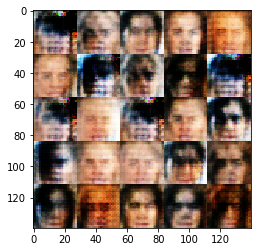

epoch descrim --->0--0.8738810420036316
epoch generate --->0--0.9957262277603149
epoch descrim --->0--0.7645729780197144
epoch generate --->0--0.901036262512207
epoch descrim --->0--1.069559097290039
epoch generate --->0--0.7715421319007874
epoch descrim --->0--0.6041956543922424
epoch generate --->0--1.44388747215271
epoch descrim --->0--0.5119290351867676
epoch generate --->0--2.11397647857666
epoch descrim --->0--0.8518509864807129
epoch generate --->0--0.9079943299293518
epoch descrim --->0--0.5499245524406433
epoch generate --->0--1.428836703300476
epoch descrim --->0--0.3386198580265045
epoch generate --->0--1.9553064107894897
epoch descrim --->0--1.7797662019729614
epoch generate --->0--0.2969387471675873
epoch descrim --->0--0.8800359964370728
epoch generate --->0--0.9146512150764465


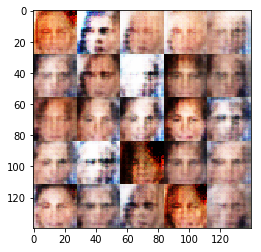

epoch descrim --->0--0.8058018088340759
epoch generate --->0--0.9240660071372986
epoch descrim --->0--1.123708963394165
epoch generate --->0--0.8368829488754272
epoch descrim --->0--0.8684624433517456
epoch generate --->0--0.8418663740158081
epoch descrim --->0--0.5313941240310669
epoch generate --->0--1.5054206848144531
epoch descrim --->0--0.7055139541625977
epoch generate --->0--1.4910088777542114
epoch descrim --->0--1.1983426809310913
epoch generate --->0--3.1285486221313477
epoch descrim --->0--0.789736807346344
epoch generate --->0--1.9214684963226318
epoch descrim --->0--1.1327590942382812
epoch generate --->0--0.6106365323066711
epoch descrim --->0--1.5622005462646484
epoch generate --->0--0.3465183973312378
epoch descrim --->0--0.5427690148353577
epoch generate --->0--1.6259182691574097


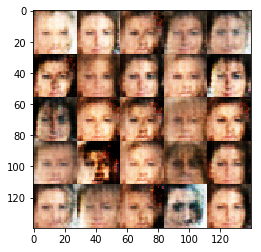

epoch descrim --->0--0.8144237995147705
epoch generate --->0--1.052132248878479
epoch descrim --->0--0.6949234008789062
epoch generate --->0--0.9992660284042358
epoch descrim --->0--0.676596462726593
epoch generate --->0--2.0374715328216553
epoch descrim --->0--1.6449449062347412
epoch generate --->0--0.37577110528945923
epoch descrim --->0--0.9105579853057861
epoch generate --->0--0.9757031202316284
epoch descrim --->0--2.0839695930480957
epoch generate --->0--0.17855361104011536
epoch descrim --->0--0.8541218042373657
epoch generate --->0--2.809743881225586
epoch descrim --->0--1.4149224758148193
epoch generate --->0--0.4639497995376587
epoch descrim --->0--0.890823245048523
epoch generate --->0--1.164121389389038
epoch descrim --->0--0.7423412799835205
epoch generate --->0--1.4887713193893433


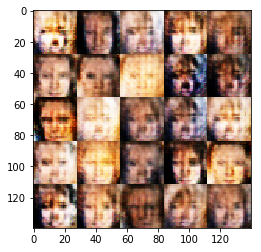

epoch descrim --->0--1.088552713394165
epoch generate --->0--0.7553354501724243
epoch descrim --->0--0.5162762999534607
epoch generate --->0--2.213078498840332
epoch descrim --->0--0.5126702189445496
epoch generate --->0--2.2184219360351562
epoch descrim --->0--1.1054219007492065
epoch generate --->0--0.7201645374298096
epoch descrim --->0--0.7667173147201538
epoch generate --->0--1.8466459512710571
epoch descrim --->0--0.8658322095870972
epoch generate --->0--1.167651653289795
epoch descrim --->0--0.3802829384803772
epoch generate --->0--1.9312360286712646
epoch descrim --->0--0.5514633059501648
epoch generate --->0--1.4328653812408447
epoch descrim --->0--0.8941439986228943
epoch generate --->0--0.9539050459861755
epoch descrim --->0--0.9732215404510498
epoch generate --->0--0.6900248527526855


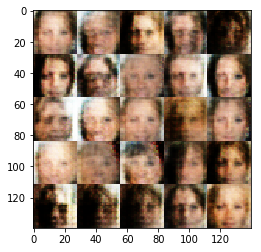

epoch descrim --->0--1.030678153038025
epoch generate --->0--0.6914772391319275
epoch descrim --->0--1.1476696729660034
epoch generate --->0--0.5728632807731628
epoch descrim --->0--0.6954692006111145
epoch generate --->0--2.3181681632995605
epoch descrim --->0--0.8221626281738281
epoch generate --->0--0.9196321964263916
epoch descrim --->0--0.6137971878051758
epoch generate --->0--1.1617692708969116
epoch descrim --->0--0.6645161509513855
epoch generate --->0--1.9311072826385498
epoch descrim --->0--0.9252910017967224
epoch generate --->0--0.90069580078125
epoch descrim --->0--1.3554027080535889
epoch generate --->0--4.966174125671387
epoch descrim --->0--0.39984846115112305
epoch generate --->0--2.191035032272339
epoch descrim --->0--0.9537031650543213
epoch generate --->0--2.9805684089660645


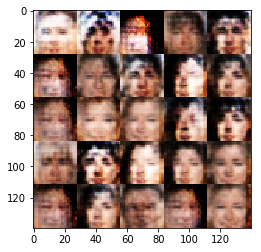

epoch descrim --->0--0.871593713760376
epoch generate --->0--0.8051371574401855
epoch descrim --->0--0.9173691272735596
epoch generate --->0--1.0993566513061523
epoch descrim --->0--0.4160693883895874
epoch generate --->0--2.4097371101379395
epoch descrim --->0--0.911700963973999
epoch generate --->0--2.030604124069214
epoch descrim --->0--0.6841633319854736
epoch generate --->0--1.712320327758789
epoch descrim --->0--0.7603034377098083
epoch generate --->0--3.0208678245544434
epoch descrim --->0--0.9818371534347534
epoch generate --->0--2.666566848754883
epoch descrim --->0--0.981892466545105
epoch generate --->0--2.2456233501434326
epoch descrim --->0--1.3672287464141846
epoch generate --->0--3.3540616035461426
epoch descrim --->0--1.2903211116790771
epoch generate --->0--0.5869473218917847


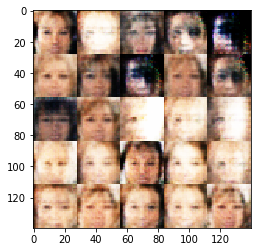

epoch descrim --->0--0.6867549419403076
epoch generate --->0--1.5383042097091675
epoch descrim --->0--0.6279057860374451
epoch generate --->0--2.1444203853607178
epoch descrim --->0--0.8896634578704834
epoch generate --->0--1.1267898082733154
epoch descrim --->0--0.6478212475776672
epoch generate --->0--1.3093037605285645
epoch descrim --->0--1.0242234468460083
epoch generate --->0--3.461848735809326
epoch descrim --->0--1.0724382400512695
epoch generate --->0--0.7163523435592651
epoch descrim --->0--1.484166145324707
epoch generate --->0--0.3718169033527374
epoch descrim --->0--0.7249181270599365
epoch generate --->0--1.06591796875
epoch descrim --->0--0.8836482763290405
epoch generate --->0--0.7361412644386292
epoch descrim --->0--0.4146442711353302
epoch generate --->0--2.643045425415039


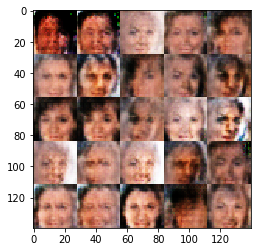

epoch descrim --->0--1.7360153198242188
epoch generate --->0--2.631080150604248
epoch descrim --->0--1.3616870641708374
epoch generate --->0--2.862729787826538
epoch descrim --->0--1.071951985359192
epoch generate --->0--0.6549019813537598
epoch descrim --->0--1.4039089679718018
epoch generate --->0--0.4226396679878235
epoch descrim --->0--1.7129483222961426
epoch generate --->0--2.8368923664093018
epoch descrim --->0--0.5427194237709045
epoch generate --->0--2.0923190116882324
epoch descrim --->0--1.1607394218444824
epoch generate --->0--0.6944960951805115
epoch descrim --->0--1.046764612197876
epoch generate --->0--0.5820491313934326
epoch descrim --->0--0.8741672039031982
epoch generate --->0--2.7172999382019043
epoch descrim --->0--0.6300291419029236
epoch generate --->0--1.33905029296875


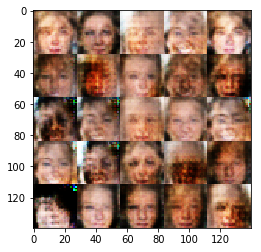

epoch descrim --->0--0.5219507813453674
epoch generate --->0--2.472702741622925
epoch descrim --->0--0.8201155662536621
epoch generate --->0--0.9908663034439087
epoch descrim --->0--0.5954662561416626
epoch generate --->0--1.1303882598876953
epoch descrim --->0--0.5678174495697021
epoch generate --->0--1.3609089851379395
epoch descrim --->0--0.4074592590332031
epoch generate --->0--1.6542161703109741
epoch descrim --->0--0.7211215496063232
epoch generate --->0--1.0310869216918945
epoch descrim --->0--0.8817373514175415
epoch generate --->0--1.1518357992172241
epoch descrim --->0--0.5709801316261292
epoch generate --->0--1.6652549505233765
epoch descrim --->0--0.6130839586257935
epoch generate --->0--2.1246156692504883
epoch descrim --->0--0.8255472779273987
epoch generate --->0--1.7641911506652832


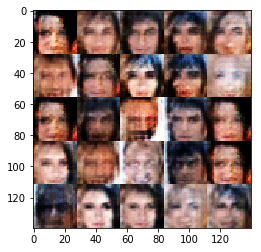

epoch descrim --->0--1.6614487171173096
epoch generate --->0--0.3961157500743866
epoch descrim --->0--0.5545936226844788
epoch generate --->0--1.4103235006332397
epoch descrim --->0--0.8679237961769104
epoch generate --->0--0.9445049166679382
epoch descrim --->0--1.037988543510437
epoch generate --->0--0.9543709754943848
epoch descrim --->0--1.388838529586792
epoch generate --->0--0.5606026649475098
epoch descrim --->0--0.596157968044281
epoch generate --->0--1.963683843612671
epoch descrim --->0--0.6109555959701538
epoch generate --->0--2.15244460105896
epoch descrim --->0--0.346437931060791
epoch generate --->0--2.0118908882141113
epoch descrim --->0--0.9087974429130554
epoch generate --->0--0.8755515217781067
epoch descrim --->0--0.7221146821975708
epoch generate --->0--1.7525672912597656


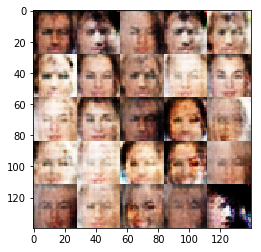

epoch descrim --->0--0.6475442051887512
epoch generate --->0--1.1010468006134033
epoch descrim --->0--1.0329279899597168
epoch generate --->0--0.751405656337738
epoch descrim --->0--0.8872536420822144
epoch generate --->0--0.9078457951545715
epoch descrim --->0--0.9941952228546143
epoch generate --->0--2.8396058082580566
epoch descrim --->0--0.7176961302757263
epoch generate --->0--1.3831920623779297
epoch descrim --->0--1.0147758722305298
epoch generate --->0--0.7363165616989136
epoch descrim --->0--1.6081911325454712
epoch generate --->0--0.36204400658607483
epoch descrim --->0--0.8664670586585999
epoch generate --->0--0.7991292476654053
epoch descrim --->0--0.913765013217926
epoch generate --->0--0.8633407950401306
epoch descrim --->0--1.541873574256897
epoch generate --->0--0.46641939878463745


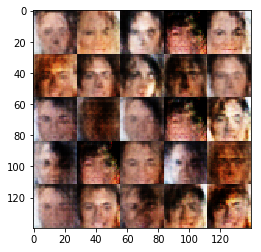

epoch descrim --->0--0.605155348777771
epoch generate --->0--2.200270652770996
epoch descrim --->0--0.6266499757766724
epoch generate --->0--1.2371971607208252
epoch descrim --->0--0.5255609154701233
epoch generate --->0--1.7704951763153076
epoch descrim --->0--0.6553738117218018
epoch generate --->0--1.3663115501403809
epoch descrim --->0--0.8819024562835693
epoch generate --->0--0.7703901529312134
epoch descrim --->0--0.4370822310447693
epoch generate --->0--1.7218642234802246
epoch descrim --->0--0.7699800133705139
epoch generate --->0--1.3438082933425903
epoch descrim --->0--0.6718490123748779
epoch generate --->0--1.725616455078125
epoch descrim --->0--0.6786011457443237
epoch generate --->0--1.4532122611999512
epoch descrim --->0--0.9291984438896179
epoch generate --->0--0.7980077266693115


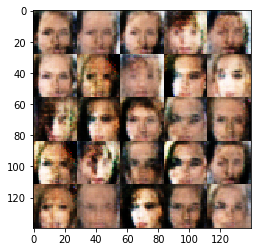

epoch descrim --->0--0.858625054359436
epoch generate --->0--1.0546176433563232
epoch descrim --->0--0.7111943960189819
epoch generate --->0--1.351288080215454
epoch descrim --->0--1.1673665046691895
epoch generate --->0--0.6001017093658447
epoch descrim --->0--0.34077200293540955
epoch generate --->0--2.390819549560547
epoch descrim --->0--1.0224748849868774
epoch generate --->0--0.7181286215782166
epoch descrim --->0--0.4002271890640259
epoch generate --->0--1.8997347354888916
epoch descrim --->0--0.6565427184104919
epoch generate --->0--1.1797086000442505
epoch descrim --->0--0.715399980545044
epoch generate --->0--1.2351329326629639
epoch descrim --->0--1.0557308197021484
epoch generate --->0--0.8736721277236938
epoch descrim --->0--0.5408549308776855
epoch generate --->0--1.4820424318313599


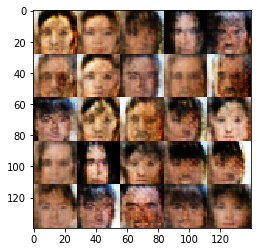

epoch descrim --->0--0.8263657093048096
epoch generate --->0--0.8335392475128174
epoch descrim --->0--1.2891732454299927
epoch generate --->0--0.4488397538661957
epoch descrim --->0--0.8526313900947571
epoch generate --->0--0.9735580682754517
epoch descrim --->0--1.898941159248352
epoch generate --->0--0.27514538168907166
epoch descrim --->0--0.5907775163650513
epoch generate --->0--2.606135845184326
epoch descrim --->0--0.9134019613265991
epoch generate --->0--0.9235676527023315
epoch descrim --->0--0.48899322748184204
epoch generate --->0--2.4665212631225586
epoch descrim --->0--0.8896928429603577
epoch generate --->0--0.8292277455329895
epoch descrim --->0--1.1823822259902954
epoch generate --->0--0.568679928779602
epoch descrim --->0--1.0011926889419556
epoch generate --->0--3.0582785606384277


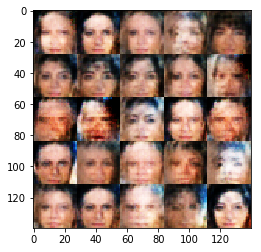

epoch descrim --->0--0.5590682029724121
epoch generate --->0--1.4320036172866821
epoch descrim --->0--1.7299600839614868
epoch generate --->0--0.31648075580596924
epoch descrim --->0--0.589729905128479
epoch generate --->0--1.3124728202819824
epoch descrim --->0--1.2759467363357544
epoch generate --->0--3.2534894943237305
epoch descrim --->0--0.9568899869918823
epoch generate --->0--3.7426185607910156
epoch descrim --->0--0.8755501508712769
epoch generate --->0--0.9481063485145569
epoch descrim --->0--0.6226102113723755
epoch generate --->0--2.7796072959899902
epoch descrim --->0--0.8993914127349854
epoch generate --->0--0.8153150081634521
epoch descrim --->0--0.7115668058395386
epoch generate --->0--1.6831547021865845
epoch descrim --->0--0.6664483547210693
epoch generate --->0--1.917785882949829


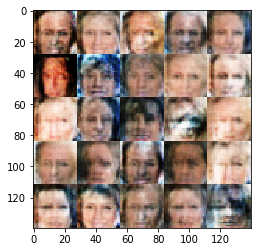

epoch descrim --->0--1.2582570314407349
epoch generate --->0--0.6069880723953247
epoch descrim --->0--0.7648971080780029
epoch generate --->0--1.2038557529449463
epoch descrim --->0--0.9878271818161011
epoch generate --->0--0.7054088115692139
epoch descrim --->0--0.8046454191207886
epoch generate --->0--0.9256157875061035
epoch descrim --->0--0.5179201364517212
epoch generate --->0--1.87055242061615
epoch descrim --->0--0.5045619010925293
epoch generate --->0--1.9842623472213745
epoch descrim --->0--0.6012348532676697
epoch generate --->0--2.2939321994781494
epoch descrim --->0--0.4634776711463928
epoch generate --->0--2.303051233291626
epoch descrim --->0--1.8070931434631348
epoch generate --->0--0.2472107708454132
epoch descrim --->0--0.8083018660545349
epoch generate --->0--1.0824801921844482


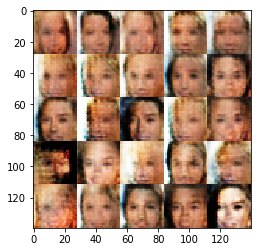

epoch descrim --->0--0.5705316662788391
epoch generate --->0--1.7592322826385498
epoch descrim --->0--0.7673797011375427
epoch generate --->0--2.941788673400879
epoch descrim --->0--0.7567203044891357
epoch generate --->0--1.2191650867462158
epoch descrim --->0--0.7866941690444946
epoch generate --->0--1.4347668886184692
epoch descrim --->0--0.6089398264884949
epoch generate --->0--1.3115816116333008
epoch descrim --->0--1.0257444381713867
epoch generate --->0--0.6592764854431152
epoch descrim --->0--0.7438541650772095
epoch generate --->0--2.7429490089416504
epoch descrim --->0--0.4715307354927063
epoch generate --->0--1.780876636505127
epoch descrim --->0--0.8286316990852356
epoch generate --->0--0.9665522575378418
epoch descrim --->0--0.7781183123588562
epoch generate --->0--0.9203978776931763


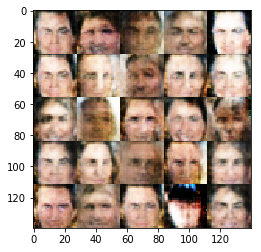

epoch descrim --->0--1.2314115762710571
epoch generate --->0--4.122008323669434
epoch descrim --->0--0.8493801355361938
epoch generate --->0--1.3619964122772217
epoch descrim --->0--1.226311206817627
epoch generate --->0--0.5054631233215332
epoch descrim --->0--0.6945855021476746
epoch generate --->0--1.9101064205169678
epoch descrim --->0--0.6457154750823975
epoch generate --->0--1.369563341140747
epoch descrim --->0--1.4192321300506592
epoch generate --->0--0.47600066661834717
epoch descrim --->0--1.1492490768432617
epoch generate --->0--0.755081295967102
epoch descrim --->0--0.6886792778968811
epoch generate --->0--1.5563958883285522
epoch descrim --->0--0.7837269306182861
epoch generate --->0--1.2582112550735474
epoch descrim --->0--0.901060938835144
epoch generate --->0--0.838090181350708


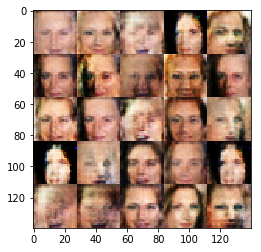

epoch descrim --->0--0.8426393270492554
epoch generate --->0--1.39589524269104
epoch descrim --->0--0.7352388501167297
epoch generate --->0--3.0299429893493652
epoch descrim --->0--0.9674666523933411
epoch generate --->0--0.930828869342804
epoch descrim --->0--0.9593573808670044
epoch generate --->0--0.8454012870788574
epoch descrim --->0--1.4834030866622925
epoch generate --->0--0.4299328029155731
epoch descrim --->0--0.3302474021911621
epoch generate --->0--3.667752742767334
epoch descrim --->0--1.091008186340332
epoch generate --->0--3.089752197265625
epoch descrim --->0--0.5286638736724854
epoch generate --->0--1.7671540975570679
epoch descrim --->0--1.2098166942596436
epoch generate --->0--0.5433437824249268
epoch descrim --->0--0.920831561088562
epoch generate --->0--0.7940046787261963


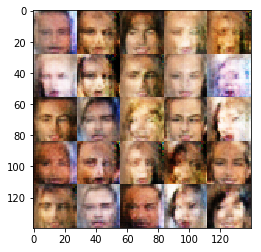

epoch descrim --->0--1.384085774421692
epoch generate --->0--0.4599291682243347
epoch descrim --->0--0.6406642198562622
epoch generate --->0--1.750379204750061
epoch descrim --->0--0.6374419927597046
epoch generate --->0--2.3004403114318848
epoch descrim --->0--0.7790808081626892
epoch generate --->0--2.128032684326172
epoch descrim --->0--0.7520508766174316
epoch generate --->0--1.0184028148651123
epoch descrim --->0--1.4621548652648926
epoch generate --->0--0.43077734112739563
epoch descrim --->0--0.7144604921340942
epoch generate --->0--1.1157824993133545
epoch descrim --->0--1.222166657447815
epoch generate --->0--0.54322350025177
epoch descrim --->0--1.3472232818603516
epoch generate --->0--0.44581201672554016
epoch descrim --->0--0.562149167060852
epoch generate --->0--1.467005968093872


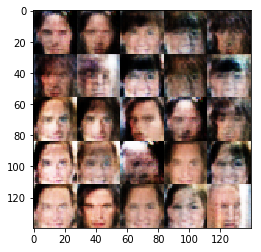

epoch descrim --->0--0.7773271799087524
epoch generate --->0--1.175086259841919
epoch descrim --->0--0.8561990261077881
epoch generate --->0--0.9405809044837952
epoch descrim --->0--1.032548427581787
epoch generate --->0--0.8456183671951294
epoch descrim --->0--1.9045689105987549
epoch generate --->0--0.22002875804901123
epoch descrim --->0--0.7454526424407959
epoch generate --->0--1.095932126045227
epoch descrim --->0--0.728165864944458
epoch generate --->0--1.2376673221588135
epoch descrim --->0--0.7966519594192505
epoch generate --->0--2.2000813484191895
epoch descrim --->0--1.2775421142578125
epoch generate --->0--3.2958292961120605
epoch descrim --->0--1.4608718156814575
epoch generate --->0--0.4933938980102539
epoch descrim --->0--0.6115638017654419
epoch generate --->0--1.8280421495437622


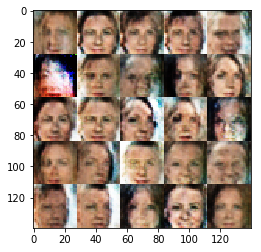

epoch descrim --->0--1.1179757118225098
epoch generate --->0--0.6313212513923645
epoch descrim --->0--0.709972620010376
epoch generate --->0--1.3732647895812988
epoch descrim --->0--1.3125520944595337
epoch generate --->0--0.4241386950016022
epoch descrim --->0--0.639961838722229
epoch generate --->0--1.3879635334014893
epoch descrim --->0--0.5856772065162659
epoch generate --->0--1.7217735052108765
epoch descrim --->0--0.5649118423461914
epoch generate --->0--1.7928364276885986
epoch descrim --->0--0.6372510194778442
epoch generate --->0--2.0396511554718018
epoch descrim --->0--1.6369740962982178
epoch generate --->0--6.225377082824707
epoch descrim --->0--1.75723135471344
epoch generate --->0--0.31739598512649536
epoch descrim --->0--0.742108941078186
epoch generate --->0--3.0708696842193604


epoch descrim --->0--0.7201129794120789
epoch generate --->0--1.100569486618042
epoch descrim --->0--0.8882802724838257
epoch generate --->0--2.9804632663726807
epoch descrim --->0--1.3274571895599365
epoch generate --->0--0.512344479560852
epoch descrim --->0--1.1627626419067383
epoch generate --->0--0.6248380541801453
epoch descrim --->0--1.7006057500839233
epoch generate --->0--0.3115319013595581
epoch descrim --->0--0.9616898894309998
epoch generate --->0--0.7347292900085449
epoch descrim --->0--0.46080201864242554
epoch generate --->0--1.885183572769165
epoch descrim --->0--0.7194569110870361
epoch generate --->0--1.7243354320526123
epoch descrim --->0--1.2675156593322754
epoch generate --->0--0.48572710156440735
epoch descrim --->0--0.9649074077606201
epoch generate --->0--3.507481098175049


epoch descrim --->0--0.7574337720870972
epoch generate --->0--1.1645643711090088
epoch descrim --->0--0.5102392435073853
epoch generate --->0--1.612659215927124
epoch descrim --->0--0.848648726940155
epoch generate --->0--0.813467264175415
epoch descrim --->0--0.8145259022712708
epoch generate --->0--1.7450475692749023
epoch descrim --->0--0.6505748629570007
epoch generate --->0--1.8091042041778564
epoch descrim --->0--1.4085538387298584
epoch generate --->0--2.2678802013397217
epoch descrim --->0--1.3399733304977417
epoch generate --->0--0.44470638036727905
epoch descrim --->0--1.0346333980560303
epoch generate --->0--0.7583802938461304
epoch descrim --->0--0.7372627854347229
epoch generate --->0--1.2479430437088013
epoch descrim --->0--1.0889297723770142
epoch generate --->0--0.8092671632766724


epoch descrim --->0--1.9977660179138184
epoch generate --->0--4.370512008666992
epoch descrim --->0--1.6492488384246826
epoch generate --->0--0.3068276047706604
epoch descrim --->0--0.7455691695213318
epoch generate --->0--1.0180950164794922
epoch descrim --->0--0.49604523181915283
epoch generate --->0--1.8411235809326172
epoch descrim --->0--0.6151214838027954
epoch generate --->0--1.290855884552002
epoch descrim --->0--0.6265009045600891
epoch generate --->0--1.9625340700149536
epoch descrim --->0--0.5988762974739075
epoch generate --->0--2.0339159965515137
epoch descrim --->0--0.6601536870002747
epoch generate --->0--2.2802505493164062
epoch descrim --->0--0.7150806188583374
epoch generate --->0--1.192113995552063
epoch descrim --->0--0.6148099899291992
epoch generate --->0--1.8411134481430054


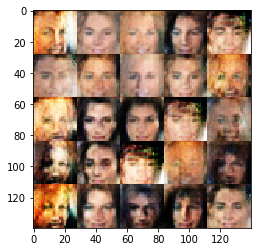

epoch descrim --->0--0.48284220695495605
epoch generate --->0--2.1115779876708984
epoch descrim --->0--0.7803131937980652
epoch generate --->0--1.1226967573165894
epoch descrim --->0--1.061202049255371
epoch generate --->0--0.5778719186782837
epoch descrim --->0--0.6762195229530334
epoch generate --->0--2.60660982131958
epoch descrim --->0--0.5073273181915283
epoch generate --->0--1.5702483654022217
epoch descrim --->0--0.5483253002166748
epoch generate --->0--1.4052737951278687
epoch descrim --->0--1.0187697410583496
epoch generate --->0--3.2028746604919434
epoch descrim --->0--0.928509533405304
epoch generate --->0--0.8327116966247559
epoch descrim --->0--1.9678739309310913
epoch generate --->0--4.580527305603027
epoch descrim --->0--1.004717469215393
epoch generate --->0--0.8097004890441895


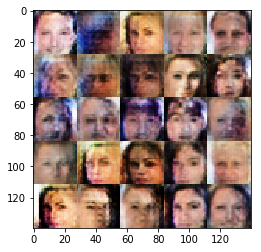

epoch descrim --->0--0.7710216045379639
epoch generate --->0--1.055741548538208
epoch descrim --->0--0.8236426115036011
epoch generate --->0--0.9737188816070557
epoch descrim --->0--0.5737384557723999
epoch generate --->0--1.4512219429016113
epoch descrim --->0--1.3233531713485718
epoch generate --->0--0.643072247505188
epoch descrim --->0--1.2025327682495117
epoch generate --->0--2.8725357055664062
epoch descrim --->0--0.7121293544769287
epoch generate --->0--2.0196635723114014
epoch descrim --->0--0.8961976766586304
epoch generate --->0--0.8386555314064026
epoch descrim --->0--0.8329757452011108
epoch generate --->0--1.9433903694152832
epoch descrim --->0--0.5342288017272949
epoch generate --->0--1.9176702499389648
epoch descrim --->0--1.105532169342041
epoch generate --->0--0.5896857976913452


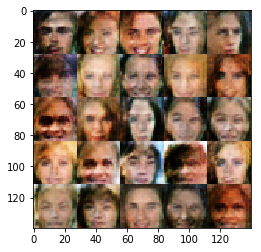

epoch descrim --->0--0.7613433599472046
epoch generate --->0--1.4501051902770996
epoch descrim --->0--0.6103050708770752
epoch generate --->0--2.3560638427734375
epoch descrim --->0--0.7271009087562561
epoch generate --->0--3.0324087142944336
epoch descrim --->0--0.8423482179641724
epoch generate --->0--0.9177732467651367
epoch descrim --->0--0.6336191296577454
epoch generate --->0--2.3939552307128906
epoch descrim --->0--0.6165791153907776
epoch generate --->0--1.3195767402648926
epoch descrim --->0--1.2095426321029663
epoch generate --->0--0.8139864206314087
epoch descrim --->0--0.7526239156723022
epoch generate --->0--1.2060436010360718
epoch descrim --->0--1.3087643384933472
epoch generate --->0--0.533593475818634
epoch descrim --->0--0.9728121757507324
epoch generate --->0--0.9502055048942566


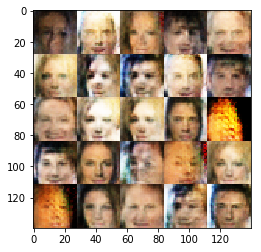

epoch descrim --->0--1.021409511566162
epoch generate --->0--0.9559866189956665
epoch descrim --->0--0.9572686553001404
epoch generate --->0--0.7481940388679504
epoch descrim --->0--0.8997474312782288
epoch generate --->0--0.9069958329200745
epoch descrim --->0--1.1278377771377563
epoch generate --->0--0.6787192821502686
epoch descrim --->0--0.6106874942779541
epoch generate --->0--1.8429982662200928
epoch descrim --->0--0.7081784009933472
epoch generate --->0--1.0972312688827515
epoch descrim --->0--1.059030294418335
epoch generate --->0--0.6811718344688416
epoch descrim --->0--0.6780557632446289
epoch generate --->0--1.3189191818237305
epoch descrim --->0--1.373062252998352
epoch generate --->0--0.5886384844779968
epoch descrim --->0--1.806946039199829
epoch generate --->0--0.34754475951194763


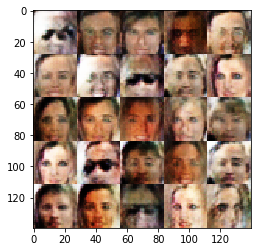

epoch descrim --->0--0.6959902048110962
epoch generate --->0--1.5119966268539429
epoch descrim --->0--1.1515692472457886
epoch generate --->0--0.6101169586181641
epoch descrim --->0--1.004587173461914
epoch generate --->0--0.777359127998352
epoch descrim --->0--0.48302578926086426
epoch generate --->0--2.2710862159729004
epoch descrim --->0--0.5566880702972412
epoch generate --->0--1.4778363704681396
epoch descrim --->0--1.0530014038085938
epoch generate --->0--0.8208887577056885
epoch descrim --->0--0.6274349689483643
epoch generate --->0--1.5505266189575195
epoch descrim --->0--0.7736163139343262
epoch generate --->0--1.198199987411499
epoch descrim --->0--1.1484107971191406
epoch generate --->0--0.5765443444252014
epoch descrim --->0--0.752630352973938
epoch generate --->0--1.0688632726669312


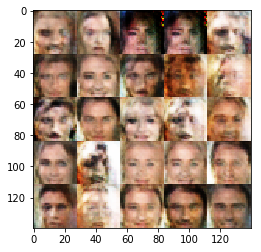

epoch descrim --->0--0.6521309018135071
epoch generate --->0--1.6816725730895996
epoch descrim --->0--0.9749173521995544
epoch generate --->0--0.7866331934928894
epoch descrim --->0--0.7310067415237427
epoch generate --->0--3.1707992553710938
epoch descrim --->0--0.6199952960014343
epoch generate --->0--1.7421109676361084
epoch descrim --->0--0.7829375267028809
epoch generate --->0--1.1162333488464355
epoch descrim --->0--0.9088283777236938
epoch generate --->0--0.8009647130966187
epoch descrim --->0--0.7123996019363403
epoch generate --->0--1.693099021911621
epoch descrim --->0--1.1806221008300781
epoch generate --->0--0.6970250606536865
epoch descrim --->0--1.5401158332824707
epoch generate --->0--0.39126771688461304
epoch descrim --->0--0.4925849437713623
epoch generate --->0--1.7787177562713623


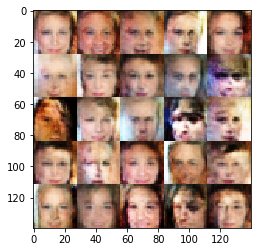

epoch descrim --->0--0.6597310304641724
epoch generate --->0--1.9185848236083984
epoch descrim --->0--1.400322675704956
epoch generate --->0--0.6011594533920288
epoch descrim --->0--0.7202059030532837
epoch generate --->0--1.874272346496582
epoch descrim --->0--0.7705264687538147
epoch generate --->0--1.1612478494644165
epoch descrim --->0--1.2368139028549194
epoch generate --->0--0.5705663561820984
epoch descrim --->0--0.7263439297676086
epoch generate --->0--2.00003981590271
epoch descrim --->0--0.8561269044876099
epoch generate --->0--0.8655571937561035
epoch descrim --->0--0.6601899862289429
epoch generate --->0--1.361508846282959
epoch descrim --->0--1.4932459592819214
epoch generate --->0--0.5363486409187317
epoch descrim --->0--1.2876254320144653
epoch generate --->0--0.5938618183135986


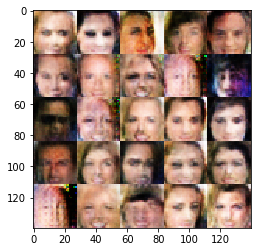

epoch descrim --->0--0.9593541622161865
epoch generate --->0--0.8252216577529907
epoch descrim --->0--0.5930311679840088
epoch generate --->0--1.7174317836761475
epoch descrim --->0--0.7897580862045288
epoch generate --->0--2.354048728942871
epoch descrim --->0--1.0354957580566406
epoch generate --->0--2.320908784866333
epoch descrim --->0--0.9090557098388672
epoch generate --->0--1.0668771266937256
epoch descrim --->0--0.6319094896316528
epoch generate --->0--1.657195806503296
epoch descrim --->0--1.0739206075668335
epoch generate --->0--0.6923515200614929
epoch descrim --->0--0.8311783075332642
epoch generate --->0--1.0328259468078613
epoch descrim --->0--0.630464494228363
epoch generate --->0--1.4196499586105347
epoch descrim --->0--0.6113951802253723
epoch generate --->0--1.2438740730285645


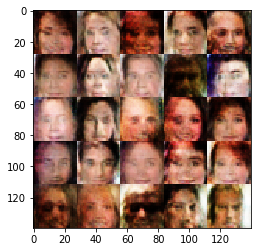

epoch descrim --->0--0.5139744877815247
epoch generate --->0--1.7728339433670044
epoch descrim --->0--1.1245100498199463
epoch generate --->0--0.6610121726989746
epoch descrim --->0--1.2992968559265137
epoch generate --->0--0.480556458234787
epoch descrim --->0--0.5773700475692749
epoch generate --->0--1.4141225814819336
epoch descrim --->0--0.5926227569580078
epoch generate --->0--1.1566877365112305
epoch descrim --->0--0.748693585395813
epoch generate --->0--1.275045394897461
epoch descrim --->0--1.0182111263275146
epoch generate --->0--0.7914065718650818
epoch descrim --->0--0.6088521480560303
epoch generate --->0--2.22324800491333
epoch descrim --->0--1.5486387014389038
epoch generate --->0--0.3412897288799286
epoch descrim --->0--0.6325722336769104
epoch generate --->0--1.4501421451568604


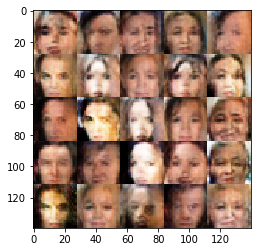

epoch descrim --->0--1.5086697340011597
epoch generate --->0--0.3886244297027588
epoch descrim --->0--0.6483067274093628
epoch generate --->0--1.5934324264526367
epoch descrim --->0--1.1110817193984985
epoch generate --->0--0.6932927966117859
epoch descrim --->0--0.6823614239692688
epoch generate --->0--2.7897067070007324
epoch descrim --->0--1.0874674320220947
epoch generate --->0--3.850811004638672
epoch descrim --->0--0.810041069984436
epoch generate --->0--0.945767879486084
epoch descrim --->0--0.6377331614494324
epoch generate --->0--1.5349485874176025
epoch descrim --->0--0.63504958152771
epoch generate --->0--1.3916242122650146
epoch descrim --->0--1.2909886837005615
epoch generate --->0--0.5322995781898499
epoch descrim --->0--1.1368545293807983
epoch generate --->0--0.6126588582992554


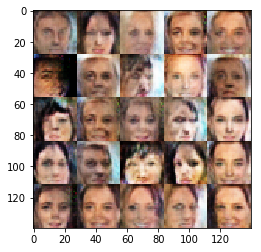

epoch descrim --->0--1.214492917060852
epoch generate --->0--0.6270790100097656
epoch descrim --->0--1.0170972347259521
epoch generate --->0--0.9106954336166382
epoch descrim --->0--1.0024709701538086
epoch generate --->0--0.8687183856964111
epoch descrim --->0--0.7149919867515564
epoch generate --->0--1.448606014251709
epoch descrim --->0--0.7423156499862671
epoch generate --->0--2.4096148014068604
epoch descrim --->0--0.7801238298416138
epoch generate --->0--1.6856584548950195
epoch descrim --->0--0.7161675691604614
epoch generate --->0--1.154200792312622
epoch descrim --->0--1.0664758682250977
epoch generate --->0--0.779523491859436
epoch descrim --->0--1.0440376996994019
epoch generate --->0--0.7337574362754822
epoch descrim --->0--1.007415771484375
epoch generate --->0--0.8151421546936035


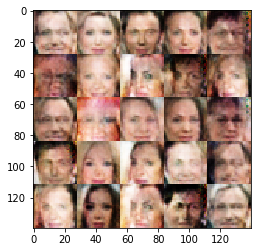

epoch descrim --->0--1.8373606204986572
epoch generate --->0--0.2927877604961395
epoch descrim --->0--0.7569399476051331
epoch generate --->0--1.1096605062484741
epoch descrim --->0--0.5681859254837036
epoch generate --->0--1.9630448818206787
epoch descrim --->0--1.220945119857788
epoch generate --->0--0.6046168804168701
epoch descrim --->0--0.6274380683898926
epoch generate --->0--3.0352869033813477
epoch descrim --->0--1.5479190349578857
epoch generate --->0--0.3718339204788208
epoch descrim --->0--0.5274070501327515
epoch generate --->0--1.7459113597869873
epoch descrim --->0--0.4775036573410034
epoch generate --->0--1.6599915027618408
epoch descrim --->0--1.5442787408828735
epoch generate --->0--0.3412479758262634
epoch descrim --->0--1.0703117847442627
epoch generate --->0--2.207528591156006


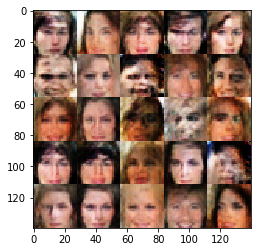

epoch descrim --->0--0.5785088539123535
epoch generate --->0--1.728340744972229
epoch descrim --->0--0.6314859390258789
epoch generate --->0--1.21708083152771
epoch descrim --->0--2.1563072204589844
epoch generate --->0--0.21944788098335266
epoch descrim --->0--0.940199613571167
epoch generate --->0--2.386460781097412
epoch descrim --->0--0.6322596073150635
epoch generate --->0--2.072326421737671
epoch descrim --->0--1.5525318384170532
epoch generate --->0--4.212874889373779
epoch descrim --->0--0.7635034918785095
epoch generate --->0--1.0525760650634766
epoch descrim --->0--1.3850897550582886
epoch generate --->0--0.48316115140914917
epoch descrim --->0--1.888790488243103
epoch generate --->0--0.2775537967681885
epoch descrim --->0--0.8364096879959106
epoch generate --->0--1.04063081741333


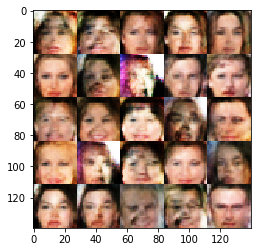

epoch descrim --->0--2.2229483127593994
epoch generate --->0--0.5853477716445923
epoch descrim --->0--1.4570891857147217
epoch generate --->0--0.5360623002052307
epoch descrim --->0--0.8042749762535095
epoch generate --->0--2.0144236087799072
epoch descrim --->0--1.2269028425216675
epoch generate --->0--0.642157793045044
epoch descrim --->0--0.6013671159744263
epoch generate --->0--1.6207425594329834
epoch descrim --->0--1.790241003036499
epoch generate --->0--0.3162309527397156
epoch descrim --->0--0.8398991823196411
epoch generate --->0--1.3454995155334473
epoch descrim --->0--0.5187682509422302
epoch generate --->0--2.5110082626342773
epoch descrim --->0--0.789592981338501
epoch generate --->0--1.621563196182251
epoch descrim --->0--0.7243635654449463
epoch generate --->0--1.1296262741088867


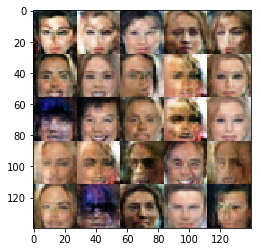

epoch descrim --->0--0.6895498633384705
epoch generate --->0--1.2094740867614746
epoch descrim --->0--0.5941970348358154
epoch generate --->0--1.7613890171051025
epoch descrim --->0--0.8280831575393677
epoch generate --->0--0.8799684643745422
epoch descrim --->0--0.897323727607727
epoch generate --->0--2.1910457611083984
epoch descrim --->0--0.7108637094497681
epoch generate --->0--1.3516006469726562
epoch descrim --->0--2.2433323860168457
epoch generate --->0--0.2004503756761551
epoch descrim --->0--0.5720304250717163
epoch generate --->0--1.7686101198196411
epoch descrim --->0--1.4211989641189575
epoch generate --->0--0.40565764904022217
epoch descrim --->0--0.7278423309326172
epoch generate --->0--1.9211467504501343
epoch descrim --->0--0.7852997779846191
epoch generate --->0--1.0487627983093262


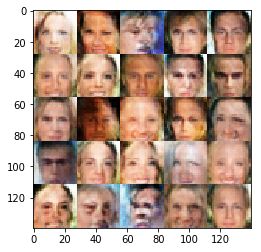

epoch descrim --->0--0.8332549929618835
epoch generate --->0--0.9791991710662842
epoch descrim --->0--0.5333752632141113
epoch generate --->0--2.6029043197631836
epoch descrim --->0--1.2037642002105713
epoch generate --->0--0.5290389060974121
epoch descrim --->0--0.685021162033081
epoch generate --->0--1.787500262260437
epoch descrim --->0--1.2662594318389893
epoch generate --->0--0.521134614944458
epoch descrim --->0--0.5700910687446594
epoch generate --->0--1.354785680770874
epoch descrim --->0--0.6302629709243774
epoch generate --->0--1.433544635772705
epoch descrim --->0--0.6449028849601746
epoch generate --->0--1.256009817123413
epoch descrim --->0--1.6745333671569824
epoch generate --->0--0.3024232089519501
epoch descrim --->0--1.5956027507781982
epoch generate --->0--0.2778872847557068


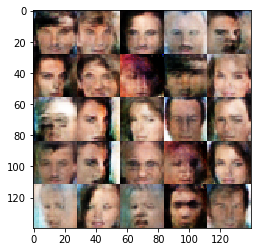

epoch descrim --->0--0.7417663335800171
epoch generate --->0--1.026707649230957
epoch descrim --->0--2.5849146842956543
epoch generate --->0--0.11421879380941391
epoch descrim --->0--1.038527488708496
epoch generate --->0--1.5178343057632446
epoch descrim --->0--0.7977222800254822
epoch generate --->0--1.1748950481414795
epoch descrim --->0--0.6785616874694824
epoch generate --->0--1.1044204235076904
epoch descrim --->0--0.5009116530418396
epoch generate --->0--1.8003568649291992
epoch descrim --->0--1.0918469429016113
epoch generate --->0--0.6269729733467102
epoch descrim --->0--1.1072903871536255
epoch generate --->0--0.6446210145950317
epoch descrim --->0--0.6608684062957764
epoch generate --->0--1.3425838947296143
epoch descrim --->0--0.6593706607818604
epoch generate --->0--2.2923998832702637


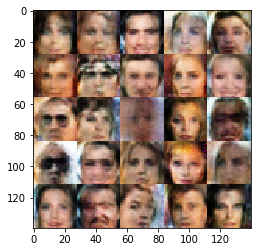

epoch descrim --->0--0.7053589820861816
epoch generate --->0--1.383740782737732
epoch descrim --->0--0.7562376260757446
epoch generate --->0--1.5831646919250488
epoch descrim --->0--0.8475350141525269
epoch generate --->0--1.138378381729126
epoch descrim --->0--1.545369267463684
epoch generate --->0--0.4118908643722534
epoch descrim --->0--0.9303826093673706
epoch generate --->0--0.8785797953605652
epoch descrim --->0--1.5355892181396484
epoch generate --->0--0.38492414355278015
epoch descrim --->0--0.6621795892715454
epoch generate --->0--1.3660707473754883
epoch descrim --->0--0.694089412689209
epoch generate --->0--1.092718482017517
epoch descrim --->0--1.4794495105743408
epoch generate --->0--0.4137440323829651
epoch descrim --->0--1.045677900314331
epoch generate --->0--0.6952806115150452


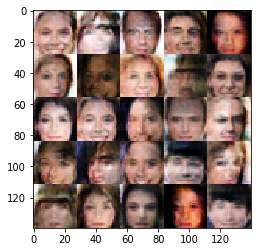

epoch descrim --->0--1.5109829902648926
epoch generate --->0--4.526302337646484


KeyboardInterrupt: 

In [77]:
batch_size = 32
z_dim = 256
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.